In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
import datetime as dt

In [97]:
train = pd.read_csv('Train.csv')
train.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,NM-2012-343889,26-04-2015,United States,Lambertfurt,Florida,Furnishings,Table Lamp,3,391.61
1,VA-2022-163003,26-04-2015,United States,West Jennifer,Nevada,Labels,Address Labels,3,579.75
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
3,WI-2014-993323,27-04-2015,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,8,854.52
4,MO-2006-118786,27-04-2015,United States,West Adam,California,Accessories,Inkjet Printer Ink,6,167.34


In [98]:
train.shape

(22291, 9)

In [99]:
train.isnull().sum()

Order ID        0
Order Date      0
Country         0
City            0
State           0
Category        0
Product Name    0
Quantity        0
Profit          0
dtype: int64

In [100]:
train.duplicated().sum()

0

In [101]:
test = pd.read_csv('Test.csv')
test.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,SD-2010-240017,23/03/2025,United States,South Mistyberg,Ohio,Copiers,Xerox 3000,3,NaN
1,OR-2023-940950,23/03/2025,United States,Riosmouth,Texas,Labels,Shipping Labels,7,NaN
2,WI-2025-418799,23/03/2025,United States,Thomasberg,Georgia,Labels,Address Labels,4,NaN
3,MT-2010-115435,23/03/2025,United States,Paynemouth,California,Storage,Mobile Pedestal,10,NaN
4,DC-2004-412546,23/03/2025,United States,Hodgeview,Florida,Accessories,Inkjet Printer Ink,5,NaN


In [102]:
test.shape

(200, 9)

In [103]:
test.isnull().sum()

Order ID          0
Order Date        0
Country           0
City              0
State             0
Category          0
Product Name      0
Quantity          0
Profit          200
dtype: int64

In [104]:
test.duplicated().sum()

0

In [105]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(22491, 9)

In [106]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22491 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22491 non-null  object 
 1   Order Date    22491 non-null  object 
 2   Country       22491 non-null  object 
 3   City          22491 non-null  object 
 4   State         22491 non-null  object 
 5   Category      22491 non-null  object 
 6   Product Name  22491 non-null  object 
 7   Quantity      22491 non-null  int64  
 8   Profit        22291 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.7+ MB


In [107]:
combined.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,NM-2012-343889,26-04-2015,United States,Lambertfurt,Florida,Furnishings,Table Lamp,3,391.61
1,VA-2022-163003,26-04-2015,United States,West Jennifer,Nevada,Labels,Address Labels,3,579.75
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
3,WI-2014-993323,27-04-2015,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,8,854.52
4,MO-2006-118786,27-04-2015,United States,West Adam,California,Accessories,Inkjet Printer Ink,6,167.34


In [108]:
combined['Product Name'].value_counts()

Product Name
Mobile Pedestal            1598
Steel Filing Cabinet       1558
Inkjet Printer Ink         1548
Vertical Stackable Tray    1535
Standing Desk              1507
Office Chair               1499
Xerox 3000                 1494
Shipping Labels            1486
Table Lamp                 1480
Address Labels             1476
Stapler                    1476
Canon ImageRunner          1465
HP LaserJet Pro            1465
Calculator                 1463
Color Coding Labels        1441
Name: count, dtype: int64

In [109]:
combined['Order Date'] = pd.to_datetime(combined['Order Date'], dayfirst=True, errors='coerce')

In [110]:
combined['Year'] = combined['Order Date'].dt.year
combined['Month'] = combined['Order Date'].dt.month
combined['Day'] = combined['Order Date'].dt.day
combined['Weekday'] = combined['Order Date'].dt.weekday
combined['Is_Weekend'] = combined['Order Date'].dt.weekday >= 5

In [111]:
combined['Profit_per_Quantity'] = combined['Profit'] / combined['Quantity']

In [112]:
combined['Total_Orders_per_City'] = combined.groupby('City')['Order ID'].transform('count')

In [113]:
combined['Total_Orders_per_State'] = combined.groupby('State')['Order ID'].transform('count')

In [114]:
combined['Total_Orders_per_Category'] = combined.groupby('Category')['Order ID'].transform('count')

In [115]:
combined['Total_Orders_per_Product'] = combined.groupby('Product Name')['Order ID'].transform('count')

In [116]:
combined = combined.drop(['Country', 'Order Date'], axis = 1)

In [138]:
le = LabelEncoder()
x = ['Order ID', 'City', 'State', 'Category', 'Product Name']
for i in x:
    combined[i] = le.fit_transform(combined[i])

In [140]:
newtrain = combined.iloc[0:22291, :]
newtest = combined.iloc[22291:, : ]
newtest = newtest.drop('Profit', axis = 1)

In [142]:
newtrain.shape

(22291, 17)

In [144]:
newtest.shape

(200, 16)

In [146]:
x = newtrain.drop('Profit', axis = 1)
y = newtrain['Profit']

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [150]:
models = {'Logistic Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(), 'CatBoost': CatBoostRegressor()}

In [152]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        cv_rmse = -cross_val_score(model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
        results[name] = cv_rmse
    return results  

In [154]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 14265, number of used features: 16
[LightGBM] [Info] Start training from score 398.425831
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 14265, number of used features: 16
[LightGBM] [Info] Start training from score 396.313634
[LightGBM] [Warning] Found

In [155]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [156]:
print(f"best model is {best_model_name} with rmse {results[best_model_name]}")

best model is Extra Tree with rmse 0.401268425120175


In [157]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [158]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.31899547916505355


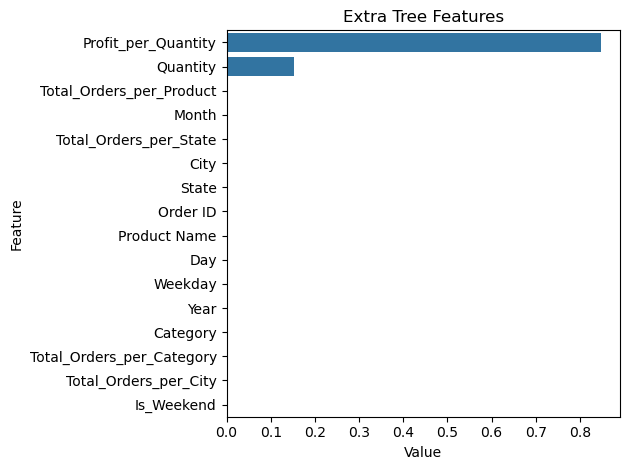

In [159]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()

In [163]:
x_train = newtrain.drop('Profit', axis = 1)
y_train = newtrain['Profit']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)
solution = pd.DataFrame({'Profit': y_pred})
solution.head()

,Profit
0,210.4333
1,393.8783
2,272.5774
3,522.5302
4,328.8490


In [164]:
solution.to_csv('Solution.csv', index = False)